In [1]:
# --- 1. Import Libraries ---
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import random

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau 
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm 
from sklearn.model_selection import train_test_split

In [2]:
# --- Function to seed everything for reproducibility ---
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [3]:
# --- 2. Define Parameters and Paths ---
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMAGE_PATH = '150_AD_CN_11112025/images'
MASK_PATH = '150_AD_CN_11112025/masks'
METADATA_PATH = '150_AD_CN_11112025/metadata.csv'
BATCH_SIZE = 16
EPOCHS = 200
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
ENCODER = 'resnext50_32x4d'
PRETRAINED_WEIGHTS = 'imagenet'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")


Using device: cuda


In [4]:
# --- 3. Data Loading and Splitting (Train-Val-Test) ---
metadata_df = pd.read_csv(METADATA_PATH)
train_val_df, test_df = train_test_split(metadata_df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42)

print(f"Total images: {len(metadata_df)}")
print(f"Training images: {len(train_df)}")
print(f"Validation images: {len(val_df)}")
print(f"Testing images: {len(test_df)}")

Total images: 150
Training images: 107
Validation images: 20
Testing images: 23


In [5]:
# --- 4. Augmentations and PyTorch Dataset ---
train_augs = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.9, 1.1), translate_percent=(-0.06, 0.06), rotate=(-20, 20), p=0.7),
    A.ElasticTransform(p=0.4, alpha=100, sigma=120 * 0.05),
    A.GridDistortion(p=0.4),
    A.RandomBrightnessContrast(p=0.4),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

val_augs = A.Compose([A.Normalize(mean=(0.5,), std=(0.5,)), ToTensorV2()])

class BrainMRIDataset(Dataset):
    def __init__(self, df, image_dir, mask_dir, augmentations=None):
        self.df = df
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.augmentations = augmentations
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row['image_id'])
        mask_path = os.path.join(self.mask_dir, row['mask_id'])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        if self.augmentations:
            transformed = self.augmentations(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        mask = mask / 255.0
        mask[mask > 0.5] = 1.0
        mask[mask <= 0.5] = 0.0
        return image, mask.permute(2, 0, 1)


In [6]:
# --- 5. Create Datasets and DataLoaders ---
train_dataset = BrainMRIDataset(train_df, IMAGE_PATH, MASK_PATH, augmentations=train_augs)
val_dataset = BrainMRIDataset(val_df, IMAGE_PATH, MASK_PATH, augmentations=val_augs)
test_dataset = BrainMRIDataset(test_df, IMAGE_PATH, MASK_PATH, augmentations=val_augs)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("DataLoaders created successfully.")

DataLoaders created successfully.


In [7]:
# --- 6. Loss Function and Metrics ---
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs, targets = inputs.view(-1), targets.view(-1)
        true_pos = (inputs * targets).sum()
        false_neg = ((1 - inputs) * targets).sum()
        false_pos = (inputs * (1 - targets)).sum()
        tversky_index = (true_pos + self.smooth) / (true_pos + self.alpha * false_neg + self.beta * false_pos + self.smooth)
        return 1 - tversky_index

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha, self.gamma, self.reduction = alpha, gamma, reduction
    def forward(self, inputs, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * bce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss

class WeightedFocalTverskyLoss(nn.Module):
    def __init__(self, focal_weight=0.8, tversky_weight=0.2):
        super(WeightedFocalTverskyLoss, self).__init__()
        self.focal_loss = FocalLoss()
        self.tversky_loss = TverskyLoss()
        self.focal_weight, self.tversky_weight = focal_weight, tversky_weight
    def forward(self, inputs, targets):
        return self.focal_weight * self.focal_loss(inputs, targets) + self.tversky_weight * self.tversky_loss(inputs, targets)
        
class BCEFocalTverskyLoss(nn.Module):
    def __init__(self, bce_weight=0.5, focal_tversky_weight=0.5):
        super(BCEFocalTverskyLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss() # More stable than Sigmoid + BCE
        self.focal_tversky_loss = WeightedFocalTverskyLoss()
        self.bce_weight = bce_weight
        self.focal_tversky_weight = focal_tversky_weight

    def forward(self, inputs, targets):
        bce = self.bce_loss(inputs, targets)
        focal_tversky = self.focal_tversky_loss(inputs, targets)
        return self.bce_weight * bce + self.focal_tversky_weight * focal_tversky

def dice_coef(y_pred, y_true, smooth=1):
    y_pred_sig = torch.sigmoid(y_pred)
    intersection = (y_pred_sig.view(-1) * y_true.view(-1)).sum()
    return (2. * intersection + smooth) / (y_pred_sig.sum() + y_true.sum() + smooth)


In [8]:
# --- 7. The Model ---
model = smp.UnetPlusPlus(encoder_name=ENCODER, encoder_weights=PRETRAINED_WEIGHTS, in_channels=1, classes=1).to(DEVICE)
print(f"Model created with a pre-trained {ENCODER} encoder.")

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

d:\ANACONDA\envs\machine_learning_pytorch\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\utkar\.cache\huggingface\hub\models--smp-hub--resnext50_32x4d.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back 

model.safetensors:   0%|          | 0.00/100M [00:00<?, ?B/s]

Model created with a pre-trained resnext50_32x4d encoder.


In [9]:
# --- 8. The Training Loop (with TQDM progress bars) ---
from tqdm import tqdm # Make sure to import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)
loss_fn = BCEFocalTverskyLoss()

# Early Stopping parameters
patience = 30
best_val_loss = float('inf')
patience_counter = 0

history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}

print("\n--- Starting Model Training ---")

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_dice = 0.0, 0.0
    
    # --- Training Phase with TQDM ---
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for images, masks in loop:
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coef(outputs, masks).item()
        
        # Update the progress bar with the current loss
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    history['train_dice'].append(avg_train_dice)

    # --- Validation Phase with TQDM ---
    model.eval()
    val_loss, val_dice = 0.0, 0.0
    with torch.no_grad():
        loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
        for images, masks in loop:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_coef(outputs, masks).item()
            
            # Update the progress bar with the current loss
            loop.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    history['val_dice'].append(avg_val_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f} | Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}")

    # Step the scheduler based on validation loss
    scheduler.step(avg_val_loss)

    # Early Stopping and Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_segmentation_model.pth')
        print("   -> Model saved (best validation loss)")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("--- Early stopping triggered ---")
            break

print("\n--- MODEL TRAINING COMPLETE ---")


--- Starting Model Training ---


d:\ANACONDA\envs\machine_learning_pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s, loss=0.436]


Epoch 1/200: Train Loss: 0.5332, Train Dice: 0.2762 | Val Loss: 0.4553, Val Dice: 0.2885
   -> Model saved (best validation loss)


Epoch 2/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s, loss=0.393]


Epoch 2/200: Train Loss: 0.3793, Train Dice: 0.3387 | Val Loss: 0.4305, Val Dice: 0.3333
   -> Model saved (best validation loss)


Epoch 3/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s, loss=0.368]


Epoch 3/200: Train Loss: 0.3273, Train Dice: 0.3691 | Val Loss: 0.4134, Val Dice: 0.3619
   -> Model saved (best validation loss)


Epoch 4/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s, loss=0.306]


Epoch 4/200: Train Loss: 0.2985, Train Dice: 0.3863 | Val Loss: 0.3295, Val Dice: 0.3588
   -> Model saved (best validation loss)


Epoch 5/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s, loss=0.271]


Epoch 5/200: Train Loss: 0.2778, Train Dice: 0.4047 | Val Loss: 0.2934, Val Dice: 0.4009
   -> Model saved (best validation loss)


Epoch 6/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.99it/s, loss=0.251]


Epoch 6/200: Train Loss: 0.2625, Train Dice: 0.4145 | Val Loss: 0.2710, Val Dice: 0.4139
   -> Model saved (best validation loss)


Epoch 7/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, loss=0.239]


Epoch 7/200: Train Loss: 0.2520, Train Dice: 0.4219 | Val Loss: 0.2575, Val Dice: 0.4157
   -> Model saved (best validation loss)


Epoch 8/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.89it/s, loss=0.234]


Epoch 8/200: Train Loss: 0.2421, Train Dice: 0.4293 | Val Loss: 0.2537, Val Dice: 0.4362
   -> Model saved (best validation loss)


Epoch 9/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s, loss=0.231]


Epoch 9/200: Train Loss: 0.2327, Train Dice: 0.4398 | Val Loss: 0.2503, Val Dice: 0.4370
   -> Model saved (best validation loss)


Epoch 10/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s, loss=0.232]


Epoch 10/200: Train Loss: 0.2241, Train Dice: 0.4498 | Val Loss: 0.2528, Val Dice: 0.4404


Epoch 11/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.84it/s, loss=0.214]


Epoch 11/200: Train Loss: 0.2180, Train Dice: 0.4573 | Val Loss: 0.2328, Val Dice: 0.4490
   -> Model saved (best validation loss)


Epoch 12/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.70it/s, loss=0.21] 


Epoch 12/200: Train Loss: 0.2148, Train Dice: 0.4581 | Val Loss: 0.2253, Val Dice: 0.4461
   -> Model saved (best validation loss)


Epoch 13/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s, loss=0.207]


Epoch 13/200: Train Loss: 0.2211, Train Dice: 0.4521 | Val Loss: 0.2235, Val Dice: 0.4582
   -> Model saved (best validation loss)


Epoch 14/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s, loss=0.203]


Epoch 14/200: Train Loss: 0.2056, Train Dice: 0.4700 | Val Loss: 0.2162, Val Dice: 0.4512
   -> Model saved (best validation loss)


Epoch 15/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s, loss=0.195]


Epoch 15/200: Train Loss: 0.2000, Train Dice: 0.4741 | Val Loss: 0.2106, Val Dice: 0.4657
   -> Model saved (best validation loss)


Epoch 16/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.78it/s, loss=0.194]


Epoch 16/200: Train Loss: 0.1991, Train Dice: 0.4805 | Val Loss: 0.2126, Val Dice: 0.4802


Epoch 17/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.71it/s, loss=0.208]


Epoch 17/200: Train Loss: 0.1982, Train Dice: 0.4758 | Val Loss: 0.2218, Val Dice: 0.4543


Epoch 18/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.68it/s, loss=0.191]


Epoch 18/200: Train Loss: 0.1970, Train Dice: 0.4818 | Val Loss: 0.2050, Val Dice: 0.4681
   -> Model saved (best validation loss)


Epoch 19/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, loss=0.186]


Epoch 19/200: Train Loss: 0.1938, Train Dice: 0.4800 | Val Loss: 0.2002, Val Dice: 0.4712
   -> Model saved (best validation loss)


Epoch 20/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.62it/s, loss=0.19]


Epoch 20/200: Train Loss: 0.1882, Train Dice: 0.4935 | Val Loss: 0.2048, Val Dice: 0.4772


Epoch 21/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.76it/s, loss=0.182]


Epoch 21/200: Train Loss: 0.1869, Train Dice: 0.4893 | Val Loss: 0.1959, Val Dice: 0.4795
   -> Model saved (best validation loss)


Epoch 22/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s, loss=0.181]


Epoch 22/200: Train Loss: 0.1813, Train Dice: 0.4935 | Val Loss: 0.1944, Val Dice: 0.4828
   -> Model saved (best validation loss)


Epoch 23/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s, loss=0.177]


Epoch 23/200: Train Loss: 0.1763, Train Dice: 0.5108 | Val Loss: 0.1923, Val Dice: 0.4975
   -> Model saved (best validation loss)


Epoch 24/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s, loss=0.173]


Epoch 24/200: Train Loss: 0.1814, Train Dice: 0.4951 | Val Loss: 0.1873, Val Dice: 0.4946
   -> Model saved (best validation loss)


Epoch 25/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.72it/s, loss=0.172]


Epoch 25/200: Train Loss: 0.1717, Train Dice: 0.5115 | Val Loss: 0.1855, Val Dice: 0.4949
   -> Model saved (best validation loss)


Epoch 26/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s, loss=0.167]


Epoch 26/200: Train Loss: 0.1704, Train Dice: 0.5142 | Val Loss: 0.1816, Val Dice: 0.5060
   -> Model saved (best validation loss)


Epoch 27/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s, loss=0.164]


Epoch 27/200: Train Loss: 0.1681, Train Dice: 0.5153 | Val Loss: 0.1782, Val Dice: 0.5098
   -> Model saved (best validation loss)


Epoch 28/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s, loss=0.164]


Epoch 28/200: Train Loss: 0.1645, Train Dice: 0.5273 | Val Loss: 0.1804, Val Dice: 0.5206


Epoch 29/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s, loss=0.161]


Epoch 29/200: Train Loss: 0.1609, Train Dice: 0.5344 | Val Loss: 0.1727, Val Dice: 0.5081
   -> Model saved (best validation loss)


Epoch 30/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s, loss=0.158]


Epoch 30/200: Train Loss: 0.1581, Train Dice: 0.5354 | Val Loss: 0.1694, Val Dice: 0.5165
   -> Model saved (best validation loss)


Epoch 31/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, loss=0.155]


Epoch 31/200: Train Loss: 0.1539, Train Dice: 0.5435 | Val Loss: 0.1693, Val Dice: 0.5218
   -> Model saved (best validation loss)


Epoch 32/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.72it/s, loss=0.154]


Epoch 32/200: Train Loss: 0.1523, Train Dice: 0.5475 | Val Loss: 0.1687, Val Dice: 0.5292
   -> Model saved (best validation loss)


Epoch 33/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s, loss=0.157]


Epoch 33/200: Train Loss: 0.1557, Train Dice: 0.5386 | Val Loss: 0.1724, Val Dice: 0.5159


Epoch 34/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s, loss=0.152]


Epoch 34/200: Train Loss: 0.1501, Train Dice: 0.5507 | Val Loss: 0.1671, Val Dice: 0.5305
   -> Model saved (best validation loss)


Epoch 35/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, loss=0.149]


Epoch 35/200: Train Loss: 0.1496, Train Dice: 0.5526 | Val Loss: 0.1635, Val Dice: 0.5354
   -> Model saved (best validation loss)


Epoch 36/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.67it/s, loss=0.147]


Epoch 36/200: Train Loss: 0.1480, Train Dice: 0.5585 | Val Loss: 0.1621, Val Dice: 0.5413
   -> Model saved (best validation loss)


Epoch 37/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.68it/s, loss=0.149]


Epoch 37/200: Train Loss: 0.1471, Train Dice: 0.5573 | Val Loss: 0.1636, Val Dice: 0.5378


Epoch 38/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.83it/s, loss=0.15] 


Epoch 38/200: Train Loss: 0.1468, Train Dice: 0.5591 | Val Loss: 0.1658, Val Dice: 0.5406


Epoch 39/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s, loss=0.146]


Epoch 39/200: Train Loss: 0.1411, Train Dice: 0.5705 | Val Loss: 0.1613, Val Dice: 0.5446
   -> Model saved (best validation loss)


Epoch 40/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s, loss=0.143]


Epoch 40/200: Train Loss: 0.1386, Train Dice: 0.5685 | Val Loss: 0.1563, Val Dice: 0.5457
   -> Model saved (best validation loss)


Epoch 41/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s, loss=0.141]


Epoch 41/200: Train Loss: 0.1405, Train Dice: 0.5683 | Val Loss: 0.1581, Val Dice: 0.5613


Epoch 42/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s, loss=0.139]


Epoch 42/200: Train Loss: 0.1372, Train Dice: 0.5789 | Val Loss: 0.1526, Val Dice: 0.5498
   -> Model saved (best validation loss)


Epoch 43/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.63it/s, loss=0.139]


Epoch 43/200: Train Loss: 0.1339, Train Dice: 0.5855 | Val Loss: 0.1531, Val Dice: 0.5603


Epoch 44/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.83it/s, loss=0.137]


Epoch 44/200: Train Loss: 0.1297, Train Dice: 0.5952 | Val Loss: 0.1514, Val Dice: 0.5654
   -> Model saved (best validation loss)


Epoch 45/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.84it/s, loss=0.134]


Epoch 45/200: Train Loss: 0.1331, Train Dice: 0.5913 | Val Loss: 0.1500, Val Dice: 0.5741
   -> Model saved (best validation loss)


Epoch 46/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s, loss=0.134]


Epoch 46/200: Train Loss: 0.1294, Train Dice: 0.5972 | Val Loss: 0.1486, Val Dice: 0.5745
   -> Model saved (best validation loss)


Epoch 47/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s, loss=0.132]


Epoch 47/200: Train Loss: 0.1269, Train Dice: 0.6024 | Val Loss: 0.1468, Val Dice: 0.5749
   -> Model saved (best validation loss)


Epoch 48/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.58it/s, loss=0.13] 


Epoch 48/200: Train Loss: 0.1257, Train Dice: 0.6044 | Val Loss: 0.1465, Val Dice: 0.5803
   -> Model saved (best validation loss)


Epoch 49/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.79it/s, loss=0.127]


Epoch 49/200: Train Loss: 0.1251, Train Dice: 0.6054 | Val Loss: 0.1414, Val Dice: 0.5868
   -> Model saved (best validation loss)


Epoch 50/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.99it/s, loss=0.135]


Epoch 50/200: Train Loss: 0.1274, Train Dice: 0.6079 | Val Loss: 0.1480, Val Dice: 0.5722


Epoch 51/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.79it/s, loss=0.132]


Epoch 51/200: Train Loss: 0.1246, Train Dice: 0.5994 | Val Loss: 0.1442, Val Dice: 0.5762


Epoch 52/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s, loss=0.128]


Epoch 52/200: Train Loss: 0.1238, Train Dice: 0.6163 | Val Loss: 0.1428, Val Dice: 0.5928


Epoch 53/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s, loss=0.128]


Epoch 53/200: Train Loss: 0.1208, Train Dice: 0.6122 | Val Loss: 0.1428, Val Dice: 0.5945


Epoch 54/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.80it/s, loss=0.124]


Epoch 54/200: Train Loss: 0.1183, Train Dice: 0.6205 | Val Loss: 0.1401, Val Dice: 0.6051
   -> Model saved (best validation loss)


Epoch 55/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.79it/s, loss=0.126]


Epoch 55/200: Train Loss: 0.1166, Train Dice: 0.6255 | Val Loss: 0.1425, Val Dice: 0.5945


Epoch 56/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s, loss=0.127]


Epoch 56/200: Train Loss: 0.1164, Train Dice: 0.6317 | Val Loss: 0.1410, Val Dice: 0.5962


Epoch 57/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s, loss=0.123]


Epoch 57/200: Train Loss: 0.1161, Train Dice: 0.6253 | Val Loss: 0.1371, Val Dice: 0.5982
   -> Model saved (best validation loss)


Epoch 58/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.90it/s, loss=0.128]


Epoch 58/200: Train Loss: 0.1153, Train Dice: 0.6323 | Val Loss: 0.1399, Val Dice: 0.5946


Epoch 59/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.65it/s, loss=0.12] 


Epoch 59/200: Train Loss: 0.1134, Train Dice: 0.6354 | Val Loss: 0.1361, Val Dice: 0.6140
   -> Model saved (best validation loss)


Epoch 60/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, loss=0.118]


Epoch 60/200: Train Loss: 0.1115, Train Dice: 0.6404 | Val Loss: 0.1350, Val Dice: 0.6207
   -> Model saved (best validation loss)


Epoch 61/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s, loss=0.118]


Epoch 61/200: Train Loss: 0.1118, Train Dice: 0.6411 | Val Loss: 0.1343, Val Dice: 0.6189
   -> Model saved (best validation loss)


Epoch 62/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.74it/s, loss=0.117]


Epoch 62/200: Train Loss: 0.1099, Train Dice: 0.6463 | Val Loss: 0.1361, Val Dice: 0.6311


Epoch 63/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s, loss=0.115]


Epoch 63/200: Train Loss: 0.1096, Train Dice: 0.6510 | Val Loss: 0.1319, Val Dice: 0.6281
   -> Model saved (best validation loss)


Epoch 64/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.89it/s, loss=0.116]


Epoch 64/200: Train Loss: 0.1069, Train Dice: 0.6551 | Val Loss: 0.1308, Val Dice: 0.6304
   -> Model saved (best validation loss)


Epoch 65/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.74it/s, loss=0.115]


Epoch 65/200: Train Loss: 0.1084, Train Dice: 0.6509 | Val Loss: 0.1294, Val Dice: 0.6274
   -> Model saved (best validation loss)


Epoch 66/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.74it/s, loss=0.119]


Epoch 66/200: Train Loss: 0.1078, Train Dice: 0.6569 | Val Loss: 0.1309, Val Dice: 0.6231


Epoch 67/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.67it/s, loss=0.117]


Epoch 67/200: Train Loss: 0.1076, Train Dice: 0.6565 | Val Loss: 0.1327, Val Dice: 0.6304


Epoch 68/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s, loss=0.111]


Epoch 68/200: Train Loss: 0.1083, Train Dice: 0.6527 | Val Loss: 0.1298, Val Dice: 0.6431


Epoch 69/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s, loss=0.112]


Epoch 69/200: Train Loss: 0.1009, Train Dice: 0.6682 | Val Loss: 0.1308, Val Dice: 0.6413


Epoch 70/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s, loss=0.109]


Epoch 70/200: Train Loss: 0.0996, Train Dice: 0.6698 | Val Loss: 0.1280, Val Dice: 0.6537
   -> Model saved (best validation loss)


Epoch 71/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.90it/s, loss=0.113]


Epoch 71/200: Train Loss: 0.0991, Train Dice: 0.6784 | Val Loss: 0.1288, Val Dice: 0.6478


Epoch 72/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s, loss=0.108]


Epoch 72/200: Train Loss: 0.0991, Train Dice: 0.6754 | Val Loss: 0.1257, Val Dice: 0.6500
   -> Model saved (best validation loss)


Epoch 73/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s, loss=0.108]


Epoch 73/200: Train Loss: 0.1001, Train Dice: 0.6739 | Val Loss: 0.1253, Val Dice: 0.6566
   -> Model saved (best validation loss)


Epoch 74/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s, loss=0.115]


Epoch 74/200: Train Loss: 0.0985, Train Dice: 0.6826 | Val Loss: 0.1298, Val Dice: 0.6503


Epoch 75/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s, loss=0.111]


Epoch 75/200: Train Loss: 0.0999, Train Dice: 0.6741 | Val Loss: 0.1244, Val Dice: 0.6543
   -> Model saved (best validation loss)


Epoch 76/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, loss=0.118]


Epoch 76/200: Train Loss: 0.0991, Train Dice: 0.6830 | Val Loss: 0.1305, Val Dice: 0.6475


Epoch 77/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s, loss=0.112]


Epoch 77/200: Train Loss: 0.0947, Train Dice: 0.6914 | Val Loss: 0.1276, Val Dice: 0.6529


Epoch 78/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s, loss=0.114]


Epoch 78/200: Train Loss: 0.0949, Train Dice: 0.6934 | Val Loss: 0.1287, Val Dice: 0.6522


Epoch 79/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s, loss=0.111]


Epoch 79/200: Train Loss: 0.0938, Train Dice: 0.6932 | Val Loss: 0.1266, Val Dice: 0.6595


Epoch 80/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.58it/s, loss=0.108]


Epoch 80/200: Train Loss: 0.0932, Train Dice: 0.6916 | Val Loss: 0.1229, Val Dice: 0.6573
   -> Model saved (best validation loss)


Epoch 81/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s, loss=0.112]


Epoch 81/200: Train Loss: 0.0934, Train Dice: 0.6940 | Val Loss: 0.1289, Val Dice: 0.6574


Epoch 82/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.62it/s, loss=0.105]


Epoch 82/200: Train Loss: 0.0915, Train Dice: 0.6990 | Val Loss: 0.1225, Val Dice: 0.6714
   -> Model saved (best validation loss)


Epoch 83/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.14it/s, loss=0.109]


Epoch 83/200: Train Loss: 0.0929, Train Dice: 0.7016 | Val Loss: 0.1233, Val Dice: 0.6601


Epoch 84/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s, loss=0.104]


Epoch 84/200: Train Loss: 0.0933, Train Dice: 0.6983 | Val Loss: 0.1230, Val Dice: 0.6697


Epoch 85/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s, loss=0.107]


Epoch 85/200: Train Loss: 0.0912, Train Dice: 0.7032 | Val Loss: 0.1257, Val Dice: 0.6734


Epoch 86/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.42it/s, loss=0.102]


Epoch 86/200: Train Loss: 0.0916, Train Dice: 0.7067 | Val Loss: 0.1211, Val Dice: 0.6750
   -> Model saved (best validation loss)


Epoch 87/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.44it/s, loss=0.0972]


Epoch 87/200: Train Loss: 0.0881, Train Dice: 0.7100 | Val Loss: 0.1175, Val Dice: 0.6860
   -> Model saved (best validation loss)


Epoch 88/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s, loss=0.0991]


Epoch 88/200: Train Loss: 0.0900, Train Dice: 0.7107 | Val Loss: 0.1173, Val Dice: 0.6801
   -> Model saved (best validation loss)


Epoch 89/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s, loss=0.0985]


Epoch 89/200: Train Loss: 0.0874, Train Dice: 0.7179 | Val Loss: 0.1172, Val Dice: 0.6856
   -> Model saved (best validation loss)


Epoch 90/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.73it/s, loss=0.105]


Epoch 90/200: Train Loss: 0.0856, Train Dice: 0.7218 | Val Loss: 0.1224, Val Dice: 0.6830


Epoch 91/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.58it/s, loss=0.0998]


Epoch 91/200: Train Loss: 0.0855, Train Dice: 0.7215 | Val Loss: 0.1198, Val Dice: 0.6899


Epoch 92/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.85it/s, loss=0.0999]


Epoch 92/200: Train Loss: 0.0881, Train Dice: 0.7100 | Val Loss: 0.1184, Val Dice: 0.6964


Epoch 93/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.85it/s, loss=0.105]


Epoch 93/200: Train Loss: 0.0891, Train Dice: 0.7132 | Val Loss: 0.1203, Val Dice: 0.6779


Epoch 94/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s, loss=0.108]


Epoch 94/200: Train Loss: 0.0903, Train Dice: 0.7079 | Val Loss: 0.1235, Val Dice: 0.6798


Epoch 95/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.75it/s, loss=0.108]


Epoch 95/200: Train Loss: 0.0861, Train Dice: 0.7198 | Val Loss: 0.1232, Val Dice: 0.6859


Epoch 96/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.84it/s, loss=0.102]


Epoch 96/200: Train Loss: 0.0852, Train Dice: 0.7239 | Val Loss: 0.1196, Val Dice: 0.6989


Epoch 97/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s, loss=0.109]


Epoch 97/200: Train Loss: 0.0828, Train Dice: 0.7338 | Val Loss: 0.1206, Val Dice: 0.6744


Epoch 98/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.83it/s, loss=0.105]


Epoch 98/200: Train Loss: 0.0827, Train Dice: 0.7279 | Val Loss: 0.1181, Val Dice: 0.6784


Epoch 99/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.74it/s, loss=0.109]


Epoch 99/200: Train Loss: 0.0831, Train Dice: 0.7309 | Val Loss: 0.1227, Val Dice: 0.6843


Epoch 100/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s, loss=0.106]


Epoch 100/200: Train Loss: 0.0824, Train Dice: 0.7346 | Val Loss: 0.1225, Val Dice: 0.6897


Epoch 101/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s, loss=0.0956]


Epoch 101/200: Train Loss: 0.0824, Train Dice: 0.7341 | Val Loss: 0.1130, Val Dice: 0.6979
   -> Model saved (best validation loss)


Epoch 102/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s, loss=0.1]  


Epoch 102/200: Train Loss: 0.0799, Train Dice: 0.7411 | Val Loss: 0.1179, Val Dice: 0.6984


Epoch 103/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s, loss=0.101]


Epoch 103/200: Train Loss: 0.0848, Train Dice: 0.7319 | Val Loss: 0.1188, Val Dice: 0.7065


Epoch 104/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.84it/s, loss=0.0993]


Epoch 104/200: Train Loss: 0.0806, Train Dice: 0.7368 | Val Loss: 0.1190, Val Dice: 0.7113


Epoch 105/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.74it/s, loss=0.0983]


Epoch 105/200: Train Loss: 0.0810, Train Dice: 0.7419 | Val Loss: 0.1169, Val Dice: 0.7102


Epoch 106/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.63it/s, loss=0.0956]


Epoch 106/200: Train Loss: 0.0790, Train Dice: 0.7410 | Val Loss: 0.1123, Val Dice: 0.7076
   -> Model saved (best validation loss)


Epoch 107/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.81it/s, loss=0.0961]


Epoch 107/200: Train Loss: 0.0791, Train Dice: 0.7404 | Val Loss: 0.1118, Val Dice: 0.7040
   -> Model saved (best validation loss)


Epoch 108/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.63it/s, loss=0.104]


Epoch 108/200: Train Loss: 0.0786, Train Dice: 0.7485 | Val Loss: 0.1174, Val Dice: 0.6980


Epoch 109/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, loss=0.0987]


Epoch 109/200: Train Loss: 0.0805, Train Dice: 0.7434 | Val Loss: 0.1163, Val Dice: 0.7078


Epoch 110/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s, loss=0.1]  


Epoch 110/200: Train Loss: 0.0778, Train Dice: 0.7458 | Val Loss: 0.1192, Val Dice: 0.7005


Epoch 111/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, loss=0.0964]


Epoch 111/200: Train Loss: 0.0802, Train Dice: 0.7424 | Val Loss: 0.1161, Val Dice: 0.7214


Epoch 112/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s, loss=0.0951]


Epoch 112/200: Train Loss: 0.0809, Train Dice: 0.7436 | Val Loss: 0.1161, Val Dice: 0.7183


Epoch 113/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s, loss=0.1]  


Epoch 113/200: Train Loss: 0.0787, Train Dice: 0.7442 | Val Loss: 0.1187, Val Dice: 0.7135


Epoch 114/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.80it/s, loss=0.0993]


Epoch 114/200: Train Loss: 0.0772, Train Dice: 0.7513 | Val Loss: 0.1170, Val Dice: 0.7189


Epoch 115/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s, loss=0.104]


Epoch 115/200: Train Loss: 0.0767, Train Dice: 0.7545 | Val Loss: 0.1176, Val Dice: 0.7030


Epoch 116/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.68it/s, loss=0.1] 


Epoch 116/200: Train Loss: 0.0821, Train Dice: 0.7422 | Val Loss: 0.1148, Val Dice: 0.7106


Epoch 117/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.84it/s, loss=0.101]


Epoch 117/200: Train Loss: 0.0738, Train Dice: 0.7572 | Val Loss: 0.1200, Val Dice: 0.7179


Epoch 118/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, loss=0.0971]


Epoch 118/200: Train Loss: 0.0751, Train Dice: 0.7629 | Val Loss: 0.1184, Val Dice: 0.7289


Epoch 119/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s, loss=0.103]


Epoch 119/200: Train Loss: 0.0768, Train Dice: 0.7574 | Val Loss: 0.1190, Val Dice: 0.7151


Epoch 120/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s, loss=0.102]


Epoch 120/200: Train Loss: 0.0756, Train Dice: 0.7641 | Val Loss: 0.1155, Val Dice: 0.7174


Epoch 121/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s, loss=0.0993]


Epoch 121/200: Train Loss: 0.0750, Train Dice: 0.7617 | Val Loss: 0.1184, Val Dice: 0.7252


Epoch 122/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, loss=0.0963]


Epoch 122/200: Train Loss: 0.0740, Train Dice: 0.7605 | Val Loss: 0.1132, Val Dice: 0.7167


Epoch 123/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.17it/s, loss=0.102]


Epoch 123/200: Train Loss: 0.0746, Train Dice: 0.7632 | Val Loss: 0.1171, Val Dice: 0.7151


Epoch 124/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s, loss=0.0989]


Epoch 124/200: Train Loss: 0.0727, Train Dice: 0.7718 | Val Loss: 0.1148, Val Dice: 0.7207


Epoch 125/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s, loss=0.0954]


Epoch 125/200: Train Loss: 0.0734, Train Dice: 0.7697 | Val Loss: 0.1126, Val Dice: 0.7292


Epoch 126/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s, loss=0.102]


Epoch 126/200: Train Loss: 0.0715, Train Dice: 0.7717 | Val Loss: 0.1184, Val Dice: 0.7173


Epoch 127/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s, loss=0.106]


Epoch 127/200: Train Loss: 0.0728, Train Dice: 0.7645 | Val Loss: 0.1213, Val Dice: 0.7121


Epoch 128/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s, loss=0.101]


Epoch 128/200: Train Loss: 0.0710, Train Dice: 0.7713 | Val Loss: 0.1182, Val Dice: 0.7247


Epoch 129/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s, loss=0.101]


Epoch 129/200: Train Loss: 0.0728, Train Dice: 0.7691 | Val Loss: 0.1181, Val Dice: 0.7252


Epoch 130/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s, loss=0.106]


Epoch 130/200: Train Loss: 0.0732, Train Dice: 0.7648 | Val Loss: 0.1217, Val Dice: 0.7142


Epoch 131/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s, loss=0.101]


Epoch 131/200: Train Loss: 0.0721, Train Dice: 0.7695 | Val Loss: 0.1193, Val Dice: 0.7287


Epoch 132/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s, loss=0.0996]


Epoch 132/200: Train Loss: 0.0746, Train Dice: 0.7681 | Val Loss: 0.1169, Val Dice: 0.7319


Epoch 133/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s, loss=0.101]


Epoch 133/200: Train Loss: 0.0752, Train Dice: 0.7679 | Val Loss: 0.1179, Val Dice: 0.7294


Epoch 134/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s, loss=0.103]


Epoch 134/200: Train Loss: 0.0708, Train Dice: 0.7676 | Val Loss: 0.1201, Val Dice: 0.7260


Epoch 135/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s, loss=0.1]  


Epoch 135/200: Train Loss: 0.0702, Train Dice: 0.7756 | Val Loss: 0.1180, Val Dice: 0.7314


Epoch 136/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s, loss=0.103]


Epoch 136/200: Train Loss: 0.0711, Train Dice: 0.7735 | Val Loss: 0.1179, Val Dice: 0.7222


Epoch 137/200 [Val]: 100%|██████████| 2/2 [00:00<00:00,  4.76it/s, loss=0.0998]

Epoch 137/200: Train Loss: 0.0713, Train Dice: 0.7690 | Val Loss: 0.1173, Val Dice: 0.7295
--- Early stopping triggered ---

--- MODEL TRAINING COMPLETE ---


In [14]:
# --- 9. Final Evaluation on the Test Set (with TQDM progress bar) ---
from tqdm import tqdm # Make sure tqdm is imported

print("\n--- Evaluating on the Test Set ---")

# Load the best performing model from training
model.load_state_dict(torch.load('best_segmentation_model.pth'))
model.eval()

test_loss = 0.0
test_dice = 0.0
with torch.no_grad():
    # Wrap the test_loader with tqdm
    loop = tqdm(test_loader, desc="Testing")
    for images, masks in loop:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images)

        loss = loss_fn(outputs, masks)
        test_loss += loss.item()
        
        dice_score = dice_coef(outputs, masks).item()
        test_dice += dice_score
        
        # Update the progress bar with the current metrics
        loop.set_postfix(loss=loss.item(), dice=dice_score)

avg_test_loss = test_loss / len(test_loader)
avg_test_dice = test_dice / len(test_loader)

print(f"\nFinal Test Set Performance:")
print(f"   - Test Loss: {avg_test_loss:.4f}")
print(f"   - Test Dice Coefficient: {avg_test_dice:.4f}")


--- Evaluating on the Test Set ---


Testing: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s, dice=0.708, loss=0.0825]


Final Test Set Performance:
   - Test Loss: 0.1106
   - Test Dice Coefficient: 0.6814



--- Plotting Training and Validation History ---


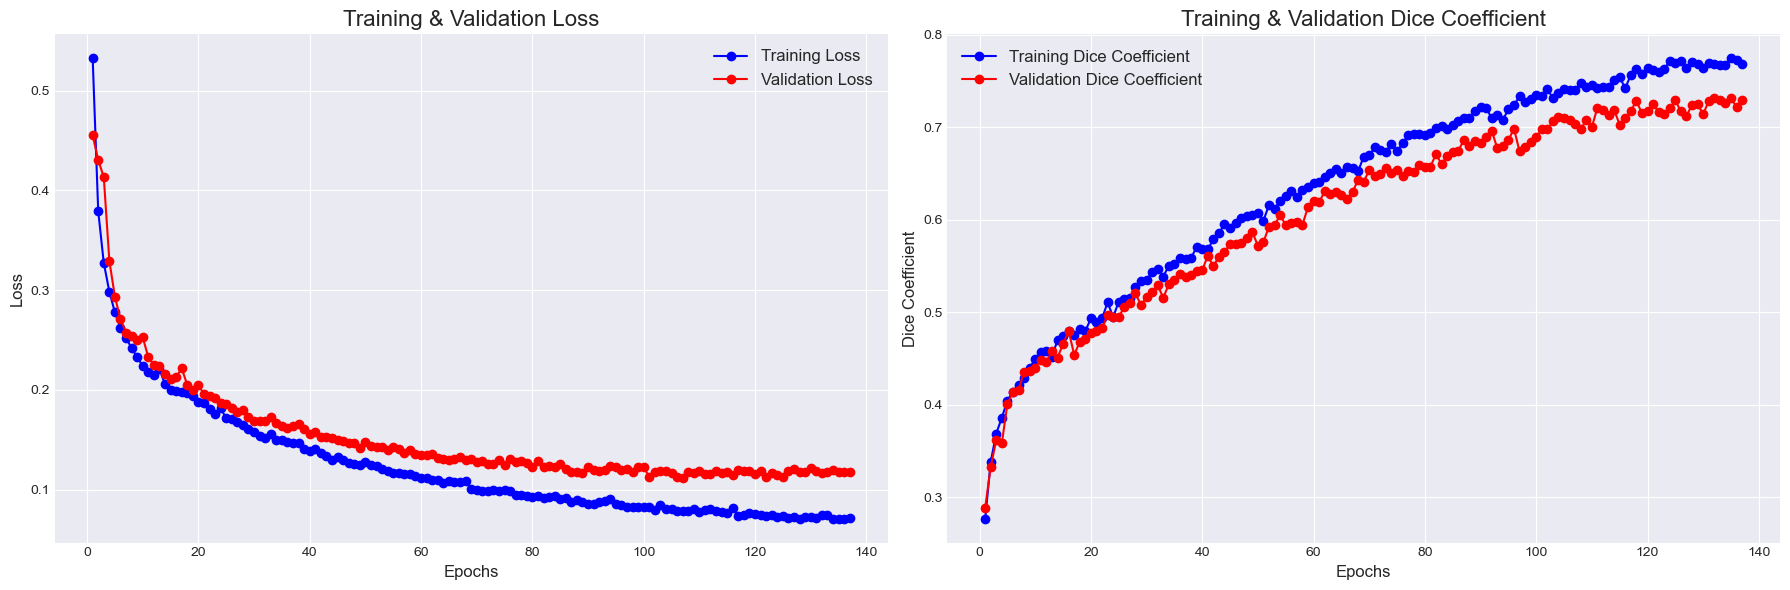


--- Best Model Weights Loaded for Final Evaluation ---


<All keys matched successfully>

In [15]:
# --- PLOTTING TRAINING HISTORY ---

print("\n--- Plotting Training and Validation History ---")

# The 'history' dictionary was populated during the training loop
train_loss = history['train_loss']
val_loss = history['val_loss']
train_dice = history['train_dice']
val_dice = history['val_dice']

# Get the number of epochs the model actually ran for
# This is important if early stopping was triggered
epochs_ran = range(1, len(train_loss) + 1)

plt.style.use('seaborn-v0_8-darkgrid') # Using a nice style for the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# --- Plot 1: Loss (Training vs. Validation) ---
ax1.plot(epochs_ran, train_loss, 'b-o', label='Training Loss')
ax1.plot(epochs_ran, val_loss, 'r-o', label='Validation Loss')
ax1.set_title('Training & Validation Loss', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True)

# --- Plot 2: Dice Coefficient (Training vs. Validation) ---
ax2.plot(epochs_ran, train_dice, 'b-o', label='Training Dice Coefficient')
ax2.plot(epochs_ran, val_dice, 'r-o', label='Validation Dice Coefficient')
ax2.set_title('Training & Validation Dice Coefficient', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Dice Coefficient', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()

# Load the best model for evaluation (this line might already be in your next cell)
# It's good practice to explicitly load it here before the test evaluation.
print("\n--- Best Model Weights Loaded for Final Evaluation ---")
model.load_state_dict(torch.load('best_segmentation_model.pth'))


--- Visualizing Sample Predictions from the Test Set ---


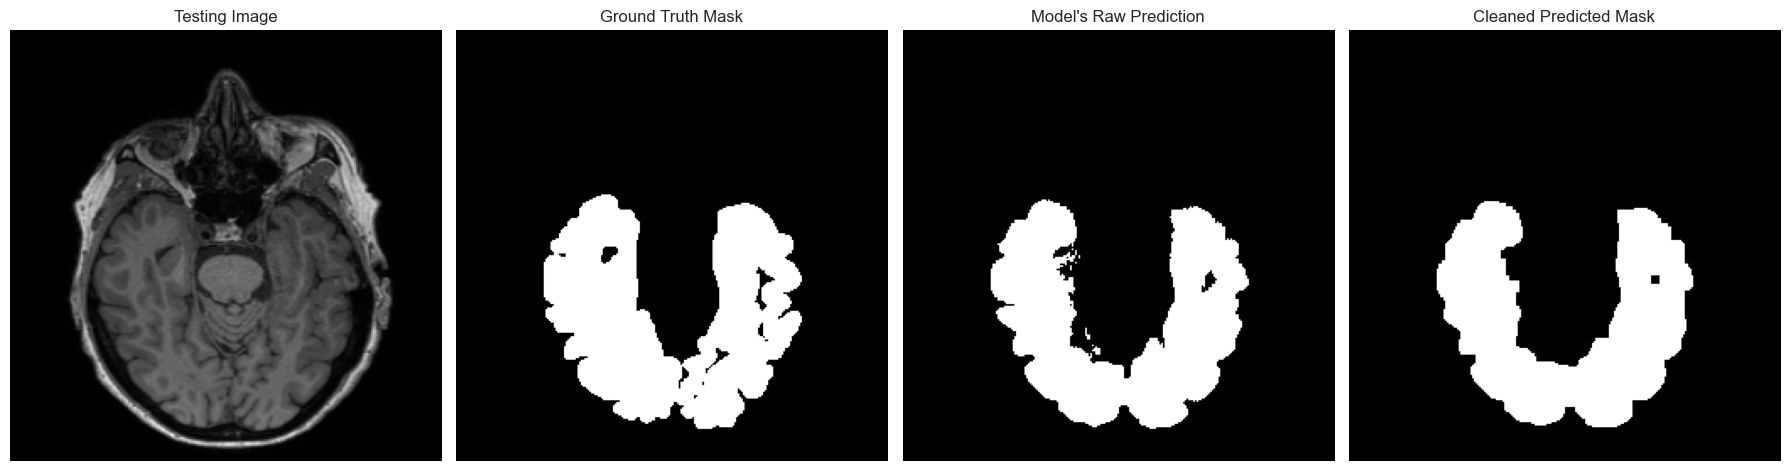

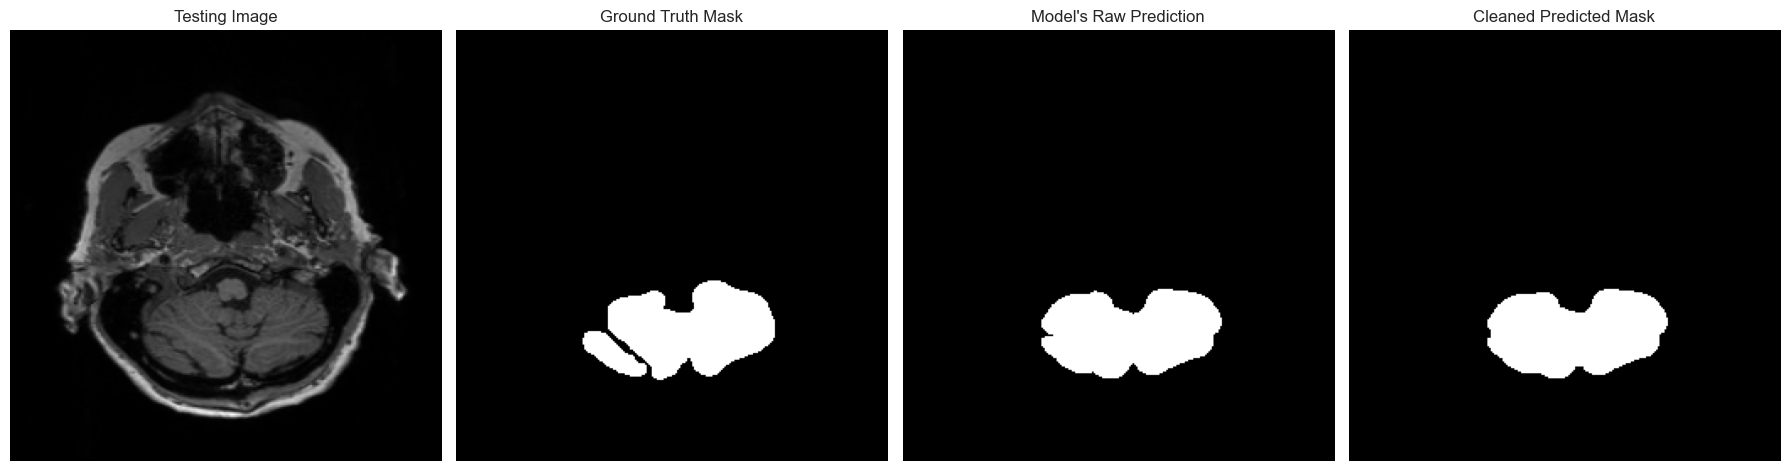

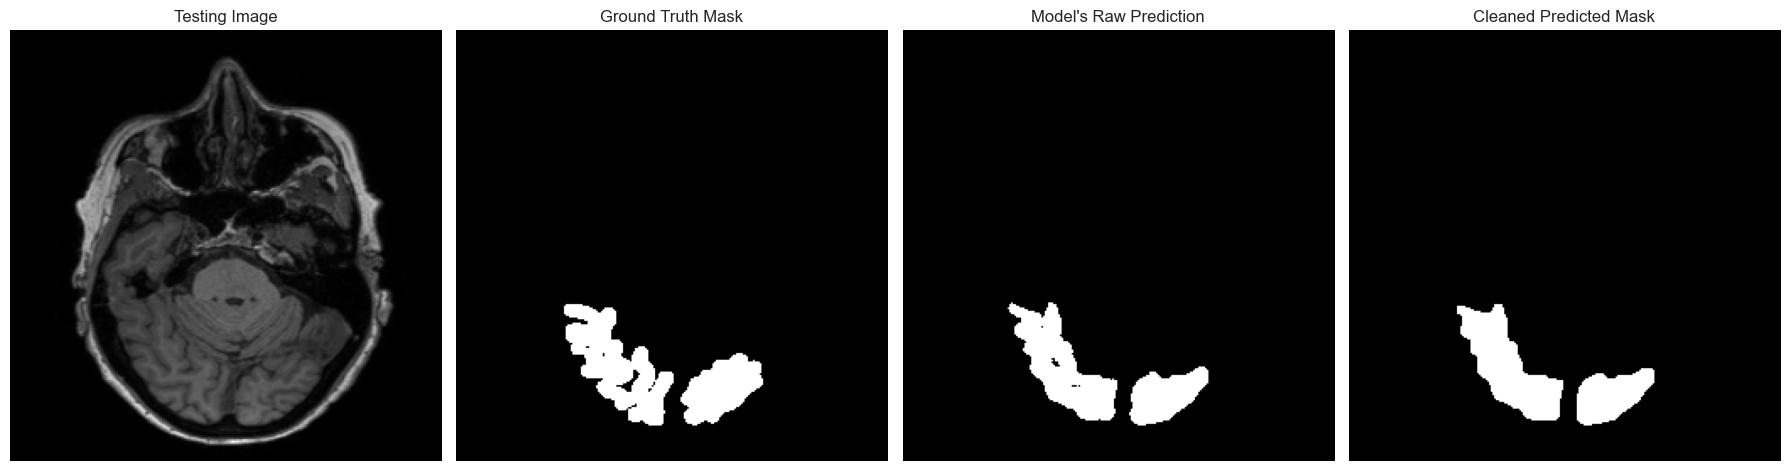

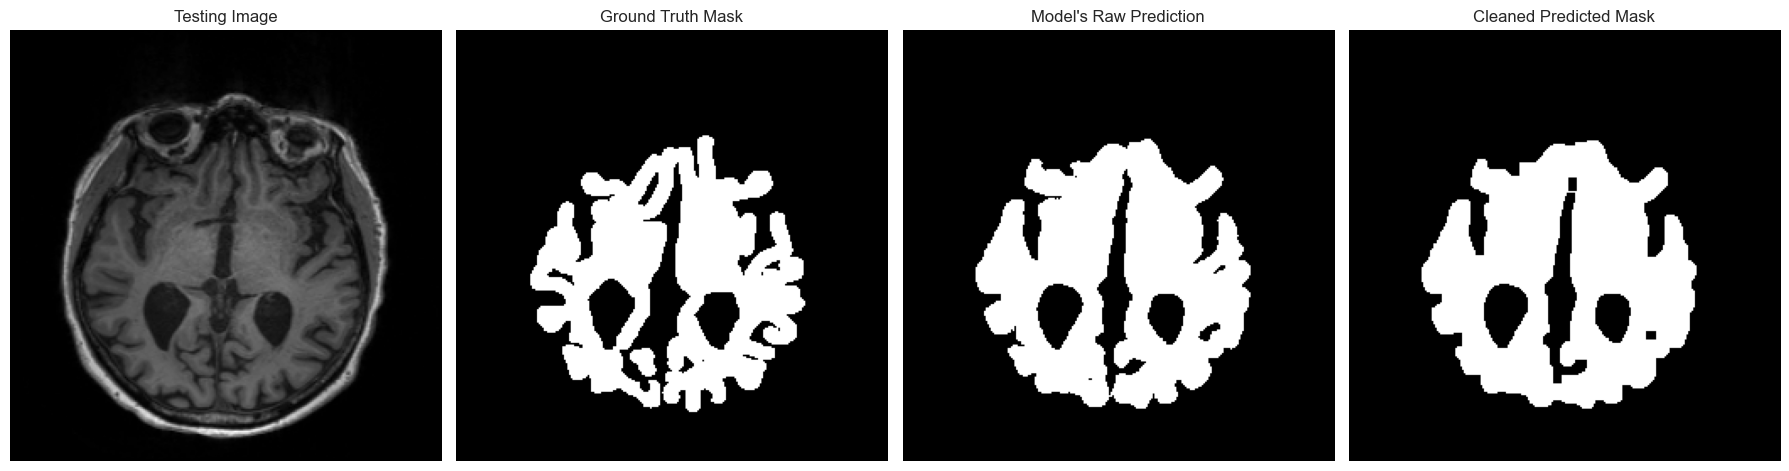

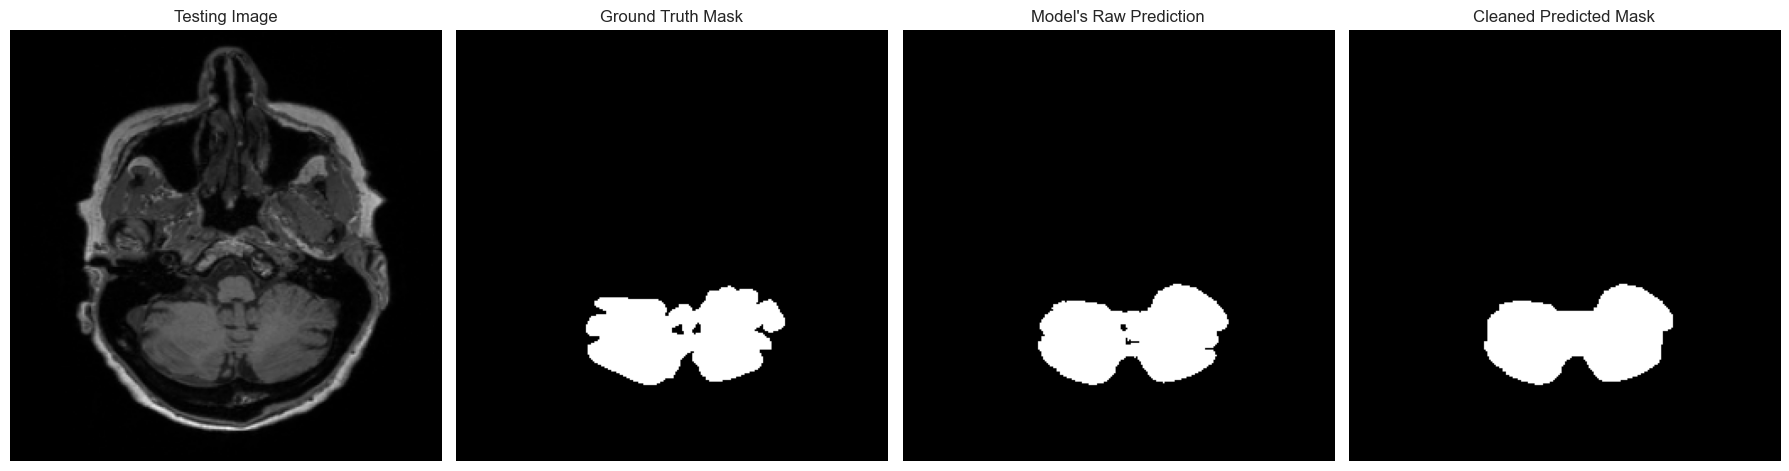

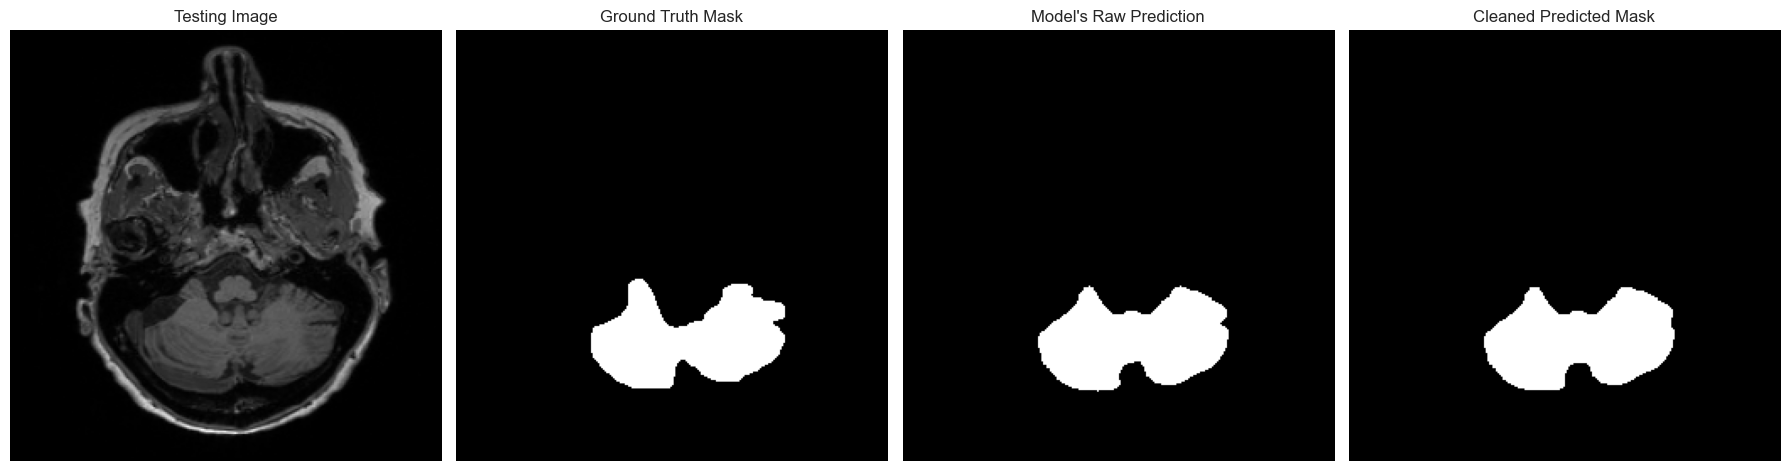

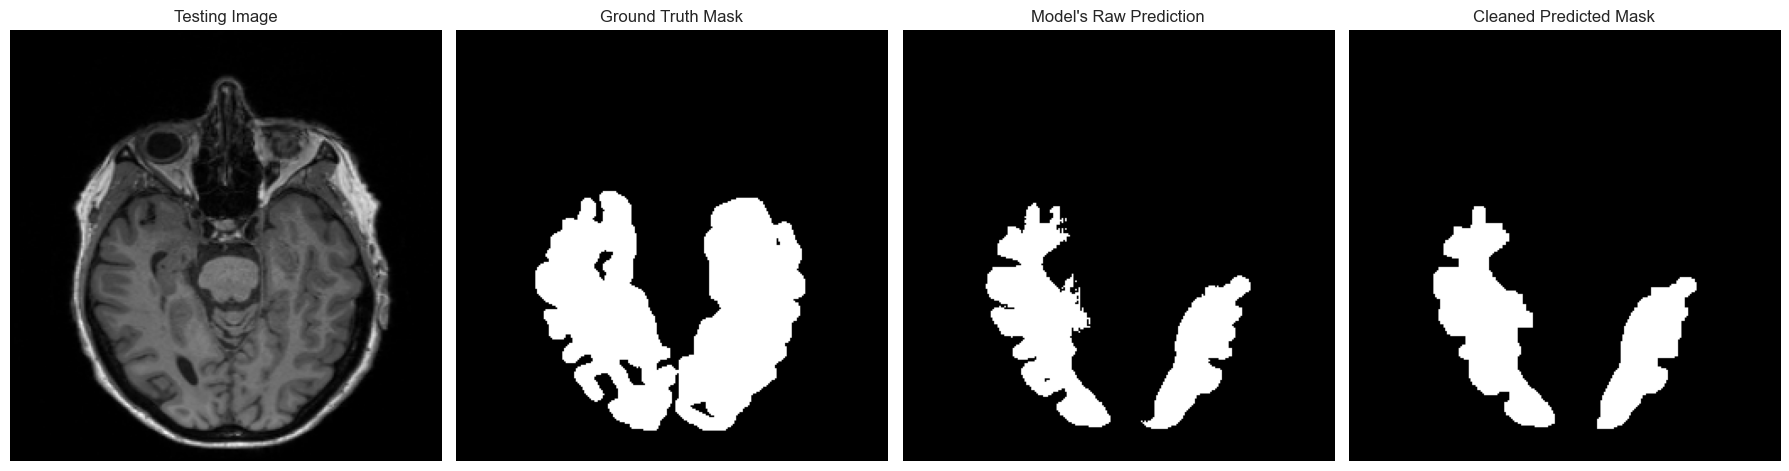

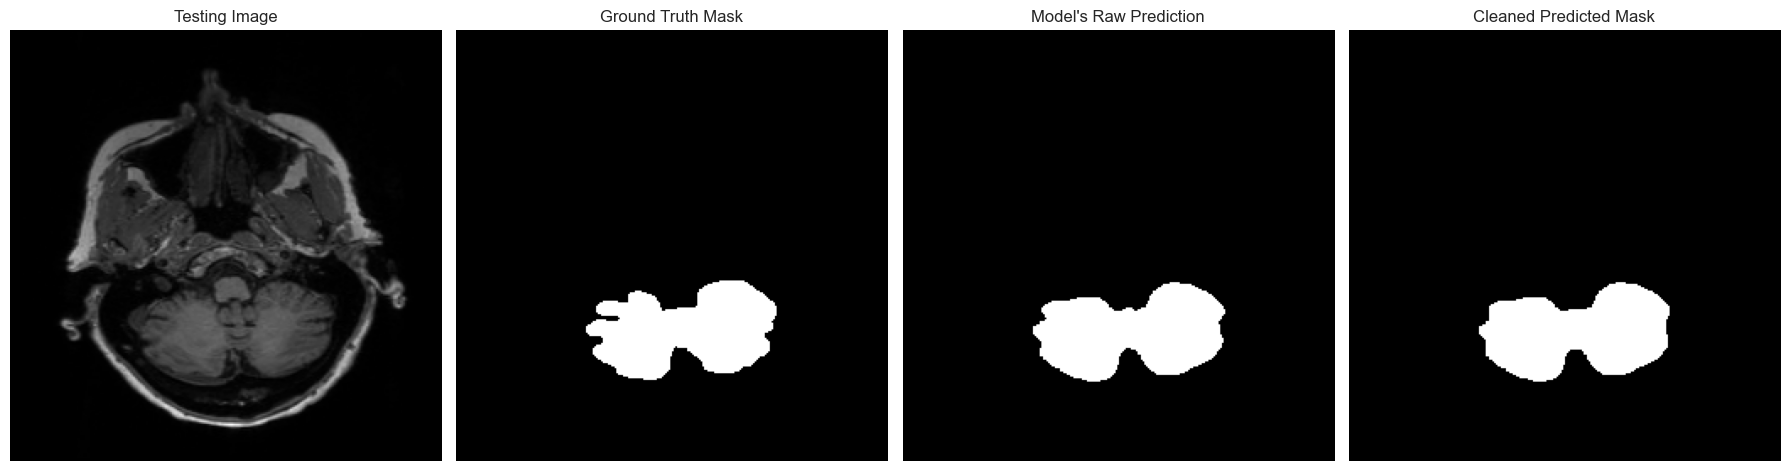

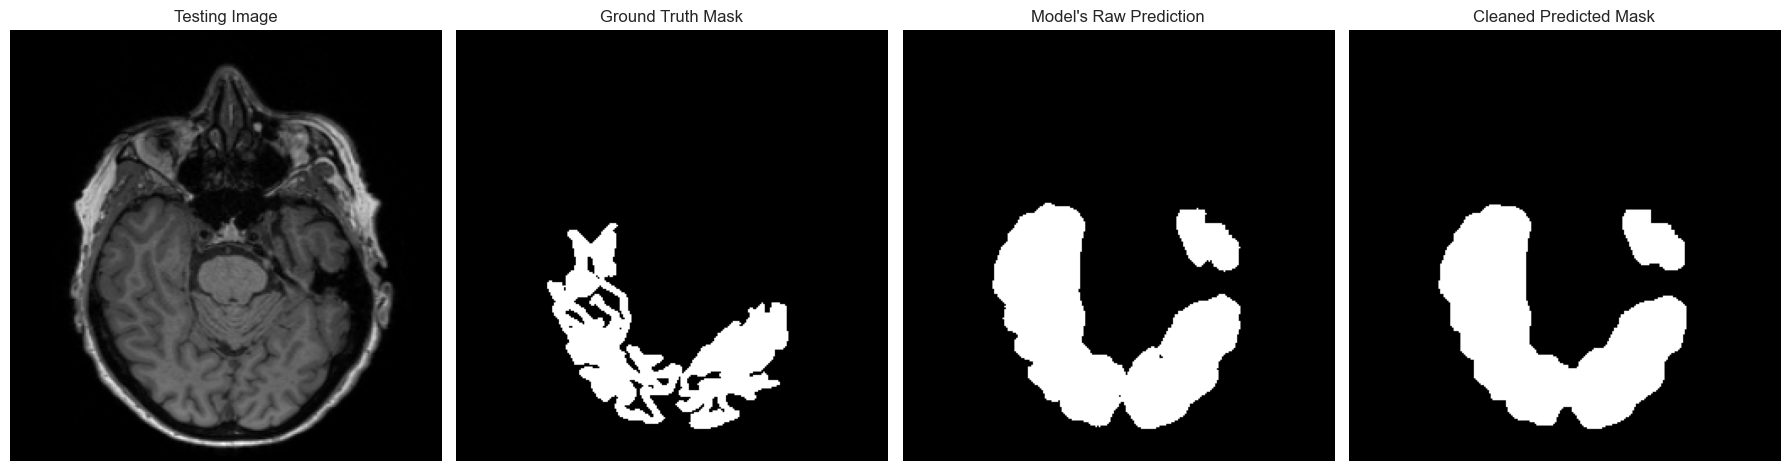

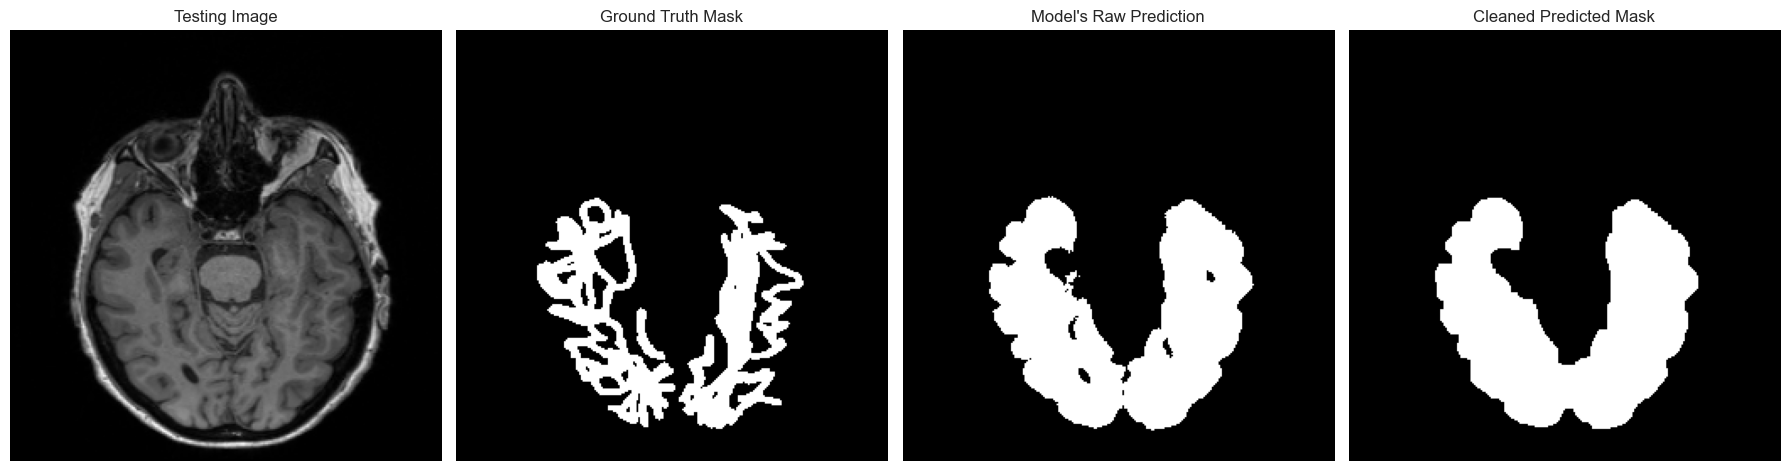

In [19]:
# --- 10. Visualization on Test Samples (with Post-Processing) ---

print("\n--- Visualizing Sample Predictions from the Test Set ---")
num_samples_to_show = 10
# Ensure we don't try to show more samples than exist in the test set
num_samples_to_show = min(num_samples_to_show, len(test_dataset))
indices = np.random.choice(range(len(test_dataset)), num_samples_to_show, replace=False)

model.eval()
with torch.no_grad():
    for i in indices:
        # Get a single image and mask from the test dataset
        test_img_tensor, ground_truth_tensor = test_dataset[i]
        
        # The model expects a batch dimension, so add it: (C, H, W) -> (B, C, H, W)
        test_img_input = test_img_tensor.unsqueeze(0).to(DEVICE)

        # Make the prediction
        prediction_prob = torch.sigmoid(model(test_img_input)).squeeze(0)
        
        # Apply threshold to get the raw predicted mask
        predicted_mask = (prediction_prob > 0.5).cpu().numpy().squeeze()

        # --- START of ADDED post-processing code ---
        # Convert to a format cv2 can use (0-255)
        cleaned_mask_np = (predicted_mask * 255).astype(np.uint8)

        # Define a kernel for morphological operations. A 3x3 or 5x5 kernel is common.
        kernel = np.ones((5, 5), np.uint8)

        # Remove small noise/speckles (Opening = erosion then dilation)
        cleaned_mask_np = cv2.morphologyEx(cleaned_mask_np, cv2.MORPH_OPEN, kernel, iterations=1)

        # Fill small holes in the main object (Closing = dilation then erosion)
        cleaned_mask_np = cv2.morphologyEx(cleaned_mask_np, cv2.MORPH_CLOSE, kernel, iterations=1)

        # Convert back to 0-1 float range for consistency if needed, though imshow handles 0-255 fine
        # For plotting, the uint8 version is fine.
        # --- END of ADDED post-processing code ---


        # Convert original tensors to numpy arrays for plotting
        test_img_np = test_img_tensor.numpy().squeeze()
        ground_truth_np = ground_truth_tensor.numpy().squeeze()
        
        # --- Plot the results ---
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 4, 1)
        plt.title('Testing Image')
        plt.imshow(test_img_np, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title('Ground Truth Mask')
        plt.imshow(ground_truth_np, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("Model's Raw Prediction")
        # Show the original, raw prediction before cleaning
        plt.imshow(predicted_mask, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.title("Cleaned Predicted Mask") # <-- Changed title
        # Show the new, cleaned mask
        plt.imshow(cleaned_mask_np, cmap='gray') # <-- Use the cleaned mask
        plt.axis('off')

        plt.tight_layout()
        plt.show()


--- Visualizing Sample Predictions from the Test Set ---


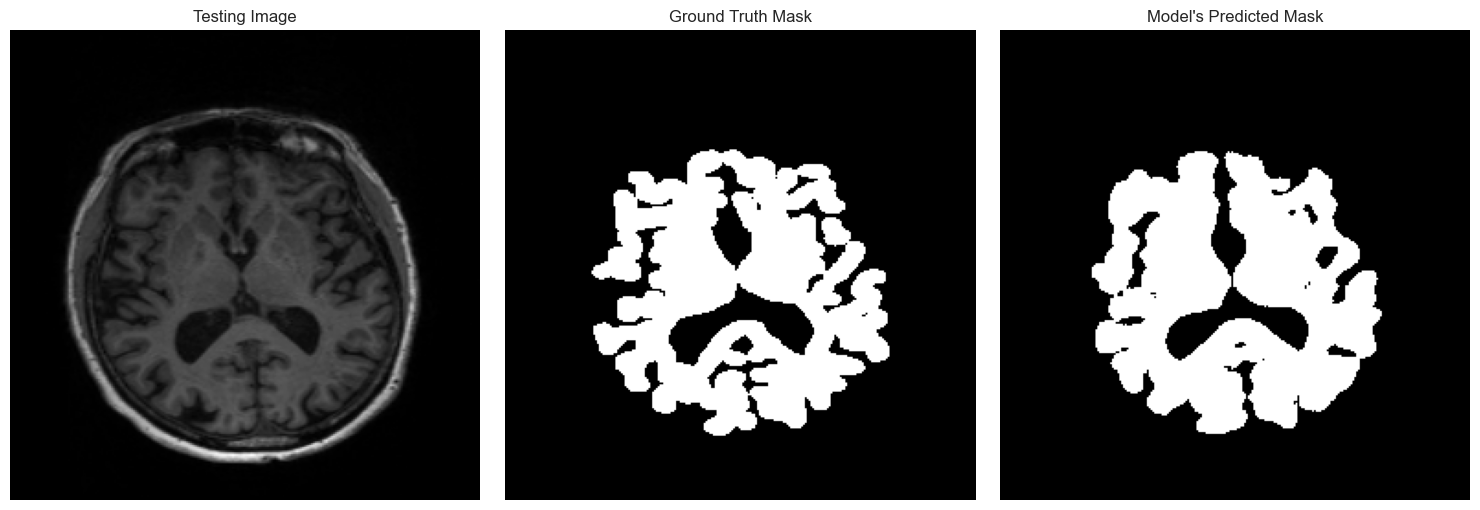

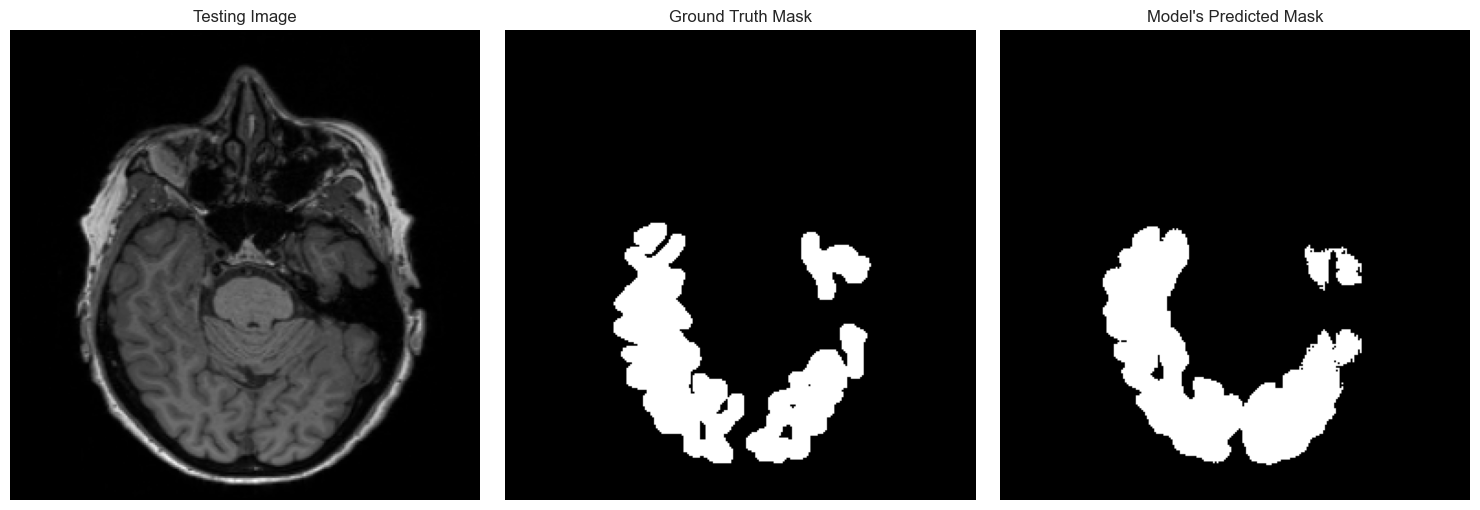

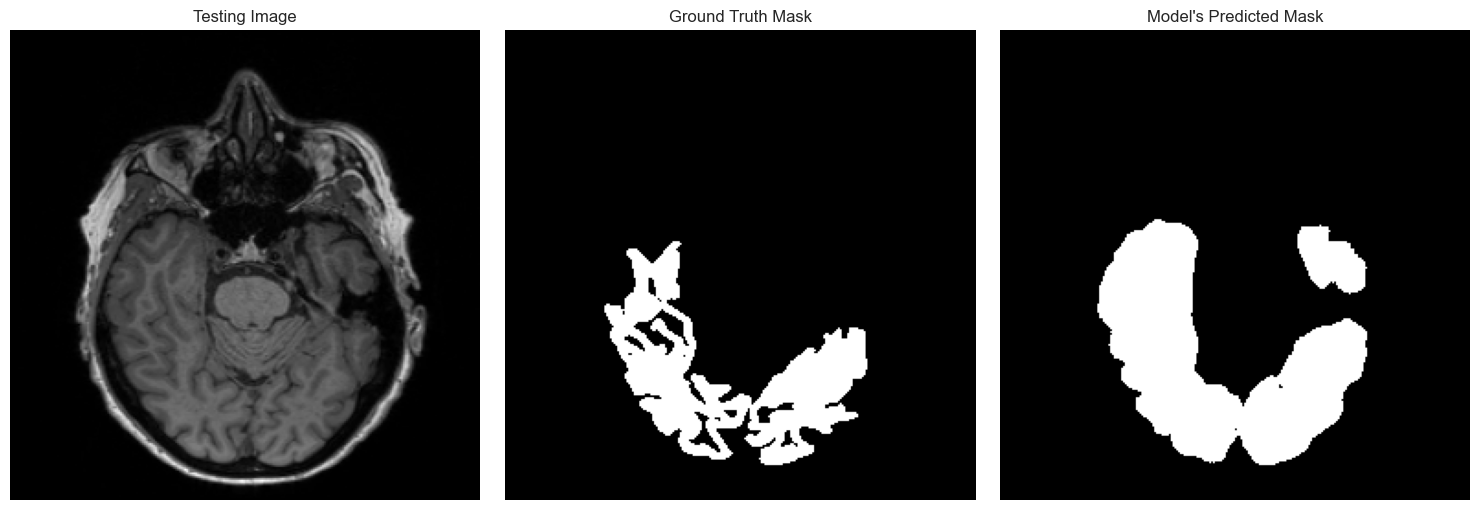

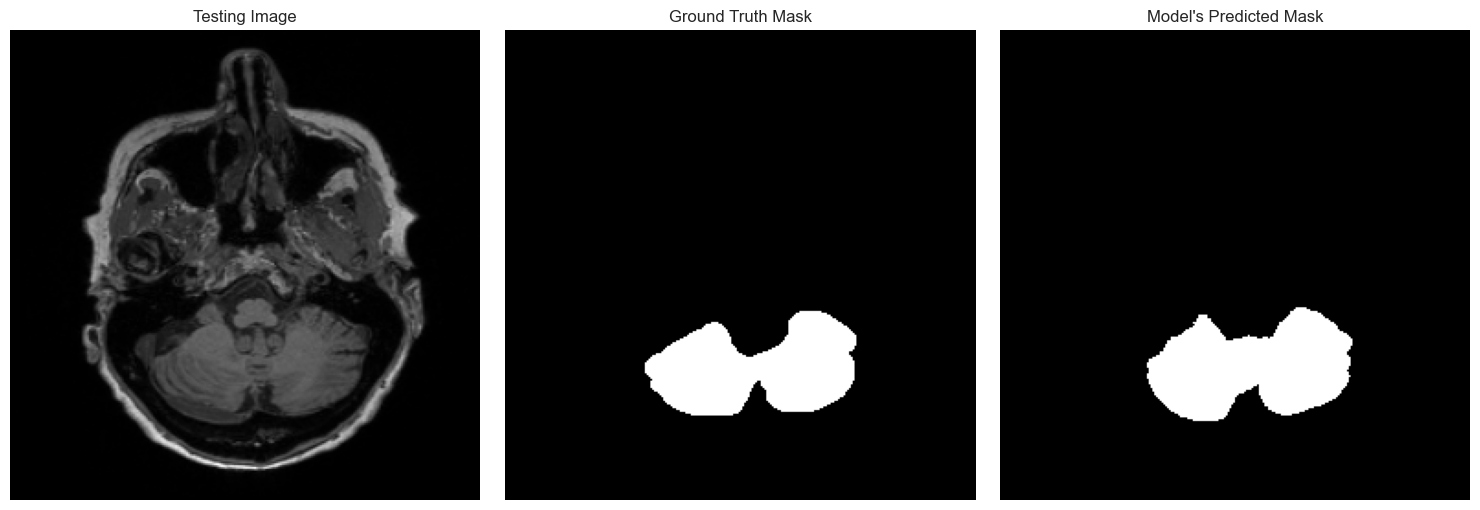

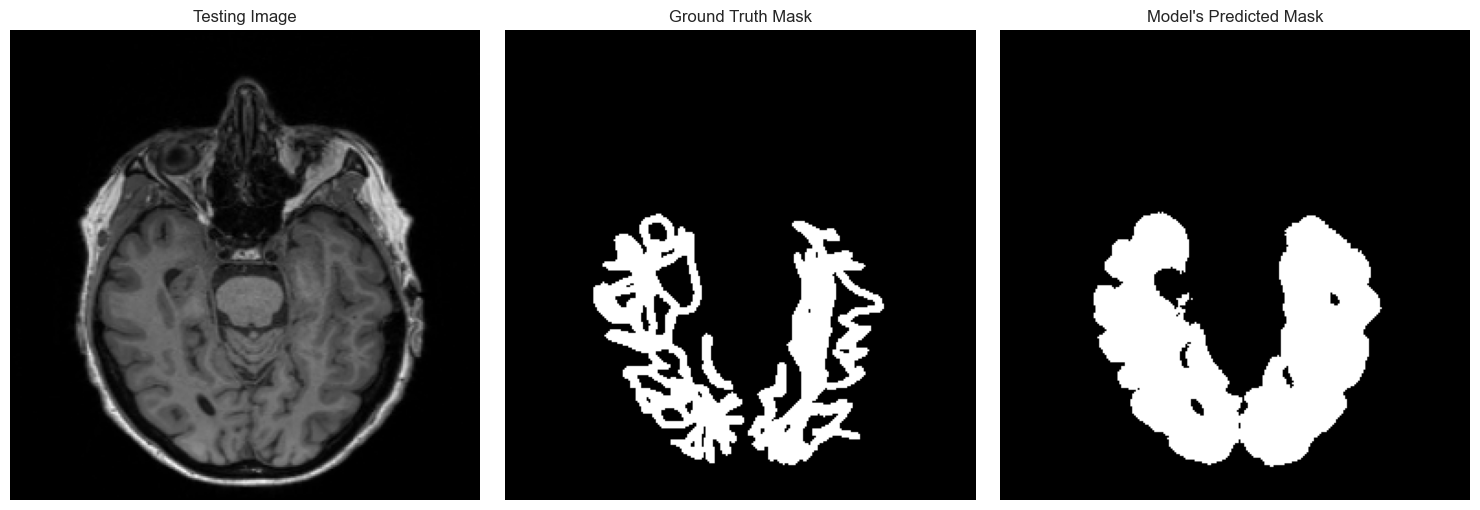

In [17]:
# --- 10. Visualization on Test Samples ---
print("\n--- Visualizing Sample Predictions from the Test Set ---")
num_samples_to_show = min(5, len(test_dataset))
indices = np.random.choice(range(len(test_dataset)), num_samples_to_show, replace=False)

model.eval()
with torch.no_grad():
    for i in indices:
        img_tensor, gt_tensor = test_dataset[i]
        img_input = img_tensor.unsqueeze(0).to(DEVICE)
        pred_prob = torch.sigmoid(model(img_input)).squeeze(0)
        pred_mask = (pred_prob > 0.5).cpu().numpy().squeeze()
        img_np, gt_np = img_tensor.numpy().squeeze(), gt_tensor.numpy().squeeze()

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Testing Image')
        plt.imshow(img_np, cmap='gray')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask')
        plt.imshow(gt_np, cmap='gray')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.title("Model's Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()